In [1]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
# import seaborn as sns
# sns.set_style('whitegrid')

from tinygp import GaussianProcess, kernels
from stingray import Lightcurve

jax.config.update("jax_enable_x64", True)

/Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/stingray/utils.py:50: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


INFO[2023-08-17 21:26:42,559]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-08-17 21:26:42,559]: Checking if light curve is sorted.


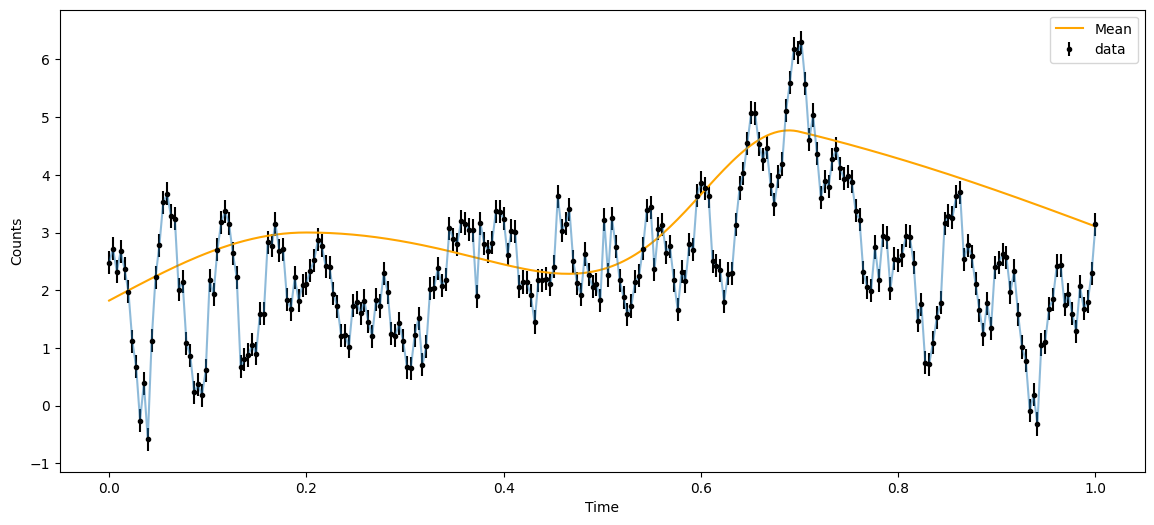

In [3]:
from gpmodelling import get_kernel, get_mean
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

Times = np.linspace(0,1,256)

# We will take suitable parameters for a high amplitude QPO with a double skew gaussian mean
kernel_params  = {"arn" : jnp.exp(1.5),    "crn" : jnp.exp(1.0),
                  "aqpo": jnp.exp(-0.4),    "cqpo": jnp.exp(1),    "freq": 20,}
kernel = get_kernel(kernel_type = "QPO_plus_RN", kernel_params = kernel_params)

mean_params = {"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), 
               "sig1" : jnp.array([0.2, 0.1]), "sig2" : jnp.array([0.3, 0.4]),  }

mean = get_mean(mean_type = "skew_gaussian",  mean_params = mean_params)

jit = 5e-2
gp = GaussianProcess(kernel = kernel, X = Times, mean_value = mean(Times), diag = jit)

# Plotting the GP
counts = sample = gp.sample(key = jax.random.PRNGKey(6))
yerr = (0.2)*np.ones_like(Times)
fig, ax = plt.subplots(1,1, figsize = (14,6))
ax.errorbar(Times, sample.T, yerr=yerr, fmt=".k", capsize=0, label="data")
ax.plot(Times, mean(Times), color = "orange" ,label = "Mean"); ax.legend()
ax.plot(Times, counts, label = "Sample GP", alpha = 0.5)
ax.set_xlabel("Time"); ax.set_ylabel("Counts")

lc = Lightcurve(time = Times, counts = counts, dt = Times[1]- Times[0])

In [4]:
def get_prior(params_list, prior_dict):
    def prior_model():
        prior_list = []
        for i in params_list:
            if isinstance(prior_dict[i], tfpd.Distribution):
                parameter = yield Prior(prior_dict[i], name=i)
            else:
                parameter = yield prior_dict[i]
            prior_list.append(parameter)
        return tuple(prior_list)
    return prior_model

def get_likelihood(params_list, kernel_type, mean_type, **kwargs):
    @jit
    def likelihood_model(*args):
        dict = {}
        for i, params in enumerate(params_list):
            dict[params] = args[i]
        kernel = get_kernel(kernel_type=kernel_type, kernel_params=dict)
        mean = get_mean(mean_type=mean_type, mean_params=dict)
        gp = GaussianProcess(kernel, kwargs["Times"], mean_value=mean(kwargs["Times"]))
        return gp.log_probability(kwargs["counts"])

    return likelihood_model

In [7]:
T = Times[-1] - Times[0]
f = 1/(Times[1]- Times[0])
print(jnp.log(1 / T), jnp.log(f))

0.0 5.541263545158426


In [8]:
import tensorflow_probability.substrates.jax as tfp
from gpmodelling import get_prior, get_likelihood, get_gp_params
tfpd = tfp.distributions
tfpb = tfp.bijectors
params_list = get_gp_params(kernel_type= "RN", mean_type = "gaussian")
print("parameters list", params_list)

counts = sample
T = Times[-1] - Times[0]
f = 1/(Times[1]- Times[0])
span = jnp.max(counts) - jnp.min(counts)

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "A": tfpd.Uniform(low = jnp.log(0.1 * span), high = jnp.log(2 * span) ), #
    "t0": tfpd.Uniform(low = Times[0] - 0.1*T, high = Times[-1] + 0.1*T),
    "sig": tfpd.Uniform(low = jnp.log(0.5 * 1 / f), high = jnp.log(2 * T) ),
    
    "arn": tfpd.Uniform(low = jnp.log(0.1 * span), high = jnp.log(2 * span) ),
    "crn": tfpd.Uniform(low = jnp.log(1 / T), high = jnp.log(f)),
}

prior_model = get_prior(params_list, prior_dict)

# likelihood_model = get_likelihood(params_list, kernel_type= "RN", mean_type = "gaussian", Times = Times, counts = counts)

def likelihood_model(arn, crn, A, t0, sig):
    kernel_params = { "arn": jnp.exp(arn), "crn": jnp.exp(crn), }
    mean_params = {"A": jnp.exp(A), "t0": t0, "sig": jnp.exp(sig)}

    kernel = get_kernel(kernel_type="RN", kernel_params=kernel_params)
    mean = get_mean(mean_type="gaussian", mean_params=mean_params)
    gp = GaussianProcess(kernel, Times, mean_value=mean(Times))

    return gp.log_probability(counts)

parameters list ['arn', 'crn', 'A', 't0', 'sig']


In [9]:
from gpmodelling import GPResult

Gpresult = GPResult(Lightcurve(time = Times, counts = counts, dt = Times[1]- Times[0]))
Gpresult.sample(prior_model = prior_model, likelihood_model = likelihood_model)

INFO[2023-08-17 21:32:54,960]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-08-17 21:32:54,962]: Checking if light curve is sorted.
INFO[2023-08-17 21:32:55,643]: Sanity check...
INFO[2023-08-17 21:32:55,850]: Sanity check passed


Simulation Complete


In [11]:
Gpresult.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 320152
# samples: 7500
# slices: 75000.0
# slices / acceptance: 15.0
# likelihood evals / sample: 42.7
# likelihood evals / slice: 4.0
--------
logZ=-212.16 +- 0.12
H=210.0
ESS=1539
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: 0.98 +- 0.22 | 0.75 / 0.99 / 1.2 | 1.09 | 1.09
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 0.46 +- 0.46 | 0.01 / 0.37 / 1.01 | 0.01 | 0.01
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 3.26 +- 0.48 | 2.71 / 3.36 / 3.73 | 3.75 | 3.75
--------
sig: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sig: -0.18 +- 0.71 | -0.83 / -0.09 / 0.51 | -0.78 | -0.78
--------
t0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
t0: 0.65 +- 0.26 | 0.29 / 0.66 / 1.0 | 0.6 | 0.6
--------


log Evidence:  -212.16249688347412


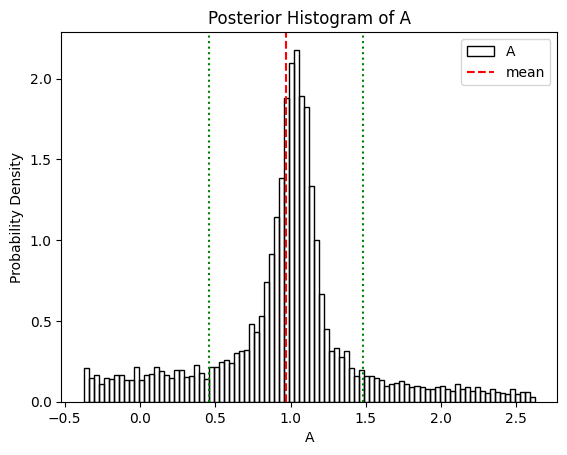

In [10]:
print("log Evidence: ", Gpresult.get_evidence())
plot = Gpresult.posterior_plot("A")
plt.show()

WARNING[2023-08-17 21:39:47,627]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


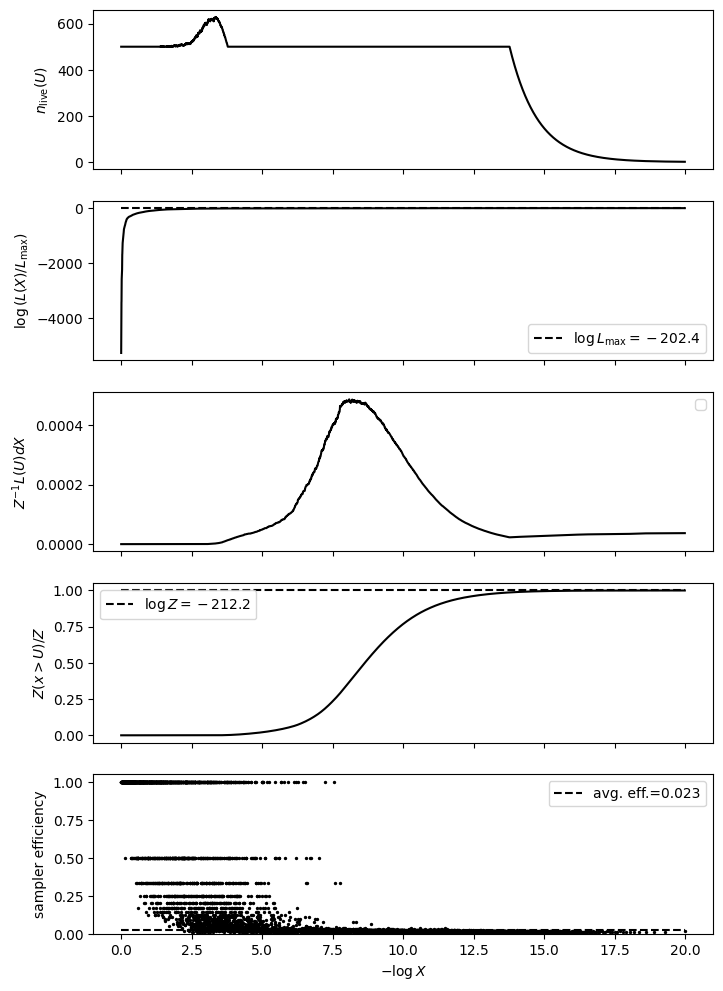

In [12]:
Gpresult.plot_diagnostics()

In [6]:
from gpmodelling import GPResult

Gpresult = GPResult(Lightcurve(time = Times, counts = counts, dt = Times[1]- Times[0]))
Gpresult.sample(prior_model = prior_model, likelihood_model = likelihood_model)

INFO[2023-08-17 17:50:47,073]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-08-17 17:50:47,076]: Checking if light curve is sorted.
INFO[2023-08-17 17:50:47,783]: Sanity check...
INFO[2023-08-17 17:50:47,991]: Sanity check passed


Simulation Complete


log Evidence:  -214.1401239186355


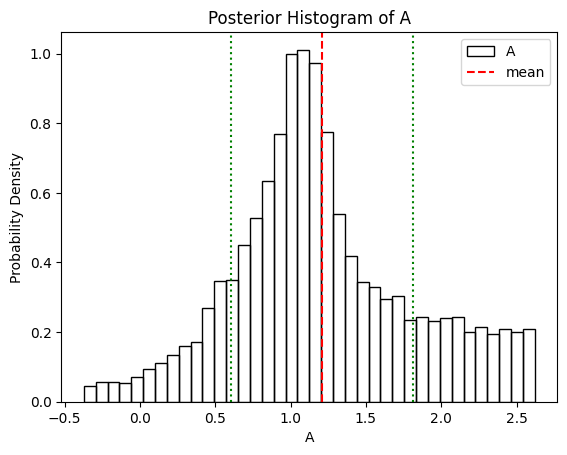

In [8]:
print("log Evidence: ", Gpresult.get_evidence())
plot = Gpresult.posterior_plot("A")
plt.show()

WARNING[2023-08-17 17:51:28,687]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


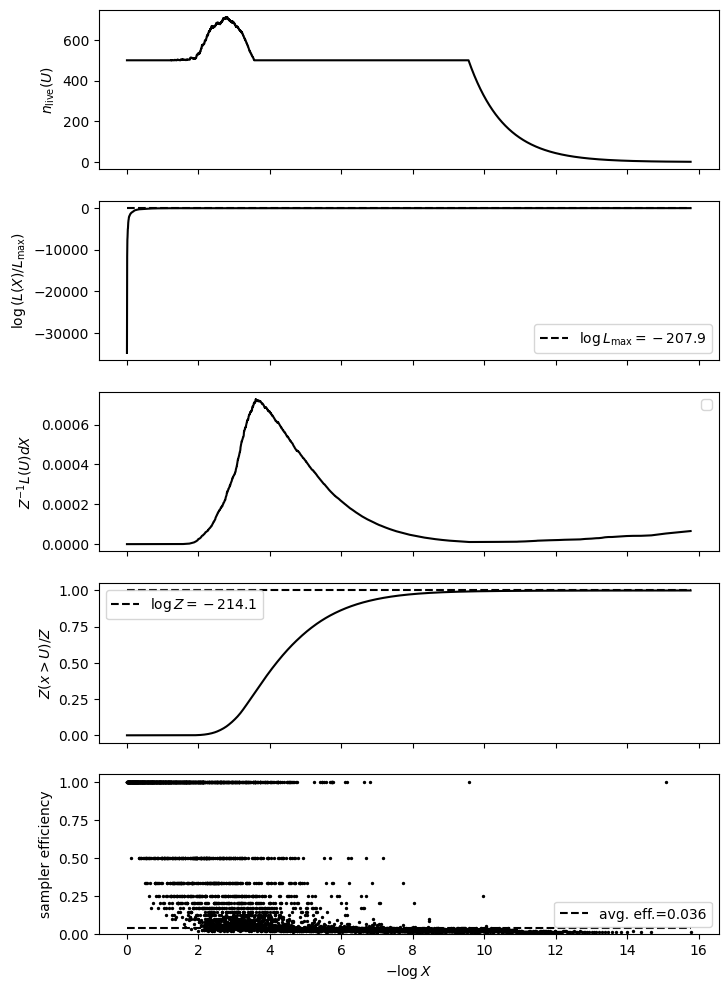

In [7]:
Gpresult.plot_diagnostics()

In [7]:
Gpresult.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 151919
# samples: 5500
# slices: 45000.0
# slices / acceptance: 15.0
# likelihood evals / sample: 27.6
# likelihood evals / slice: 3.0
--------
logZ=-214.14 +- 0.074
H=210.0
ESS=1120
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: 3.3 +- 1.7 | 1.3 / 3.1 / 5.4 | 2.9 | 2.9
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 9.5 +- 2.0 | 7.2 / 9.1 / 12.6 | 7.9 | 7.9
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 4.25 +- 0.81 | 3.15 / 4.33 / 5.3 | 4.87 | 4.87
--------
sig: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sig: 1.09 +- 0.54 | 0.33 / 1.12 / 1.8 | 0.01 | 0.01
--------
t0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
t0: 0.5 +- 0.35 | 0.02 / 0.52 / 0.99 | 0.7 | 0.7
--------


## Making own priors and log_likelihood functions

We can also construct our own prior and likelihood function, and we will demonstrate the QPO model by constructing our own prior function, and log_likelihood functions.

In [42]:
# QPO prior
from jaxns import Prior
from jaxns.special_priors import ForcedIdentifiability
from jaxns.types import float_type

params_list3 = get_gp_params(kernel_type= "QPO_plus_RN", mean_type = "gaussian")
print(params_list3)

counts = sample
T = Times[-1] - Times[0]
f = 1/(Times[1]- Times[0])
span = jnp.max(counts) - jnp.min(counts)

# Here, we have made mutiple mean function with 2 gaussians.
def prior_model3():
    arn = yield Prior(tfpb.Log()(tfpd.Uniform(low = 0.1 * span, high = 2 * span)), name='arn')
    crn = yield Prior(tfpb.Log()(tfpd.Uniform(low = jnp.log(1 / T), high = jnp.log(f))), name='crn')
    aqpo = yield Prior(tfpb.Log()(tfpd.Uniform(low = 0.1 * span, high = 2 * span)), name='aqpo')
    cqpo = yield Prior(tfpb.Log()(tfpd.Uniform(low = 1/10/T, high = jnp.log(f))), name='cqpo')
    freq = yield Prior(tfpd.Uniform(low = 2 , high = f/4 ), name='freq')

    n = 2
    A = yield Prior(tfpb.Log()(tfpd.Uniform(low = 0.1 * span*jnp.ones(n), high = 2 * span*jnp.ones(n))), name='A')
    
    # This is special conditional beta function for the peak times of gaussians which prevents degeneracies
    t0 = []
    scale_bij = tfp.bijectors.Scale(scale = Times[-1] - Times[0])
    shift_bij = tfp.bijectors.Shift(shift= Times[0])
    for i in range(n):
        underlying_beta = tfpd.Beta(
            concentration1=jnp.asarray(1., float_type),
            concentration0=jnp.asarray(n - i, float_type)
        )
        t = yield Prior(shift_bij(scale_bij(underlying_beta)), name=f"t{i}")
        # Updating the shift and scale here
        scale_bij = tfp.bijectors.Scale(scale= Times[-1] - t)
        shift_bij = tfp.bijectors.Shift(shift=t)
        t0.append(t)
    t0 = jnp.stack(t0)
    
    sig = yield Prior(tfpb.Log()(tfpd.Uniform(low = 0.5 * 1 / f *jnp.ones(n), high = 2 * T *jnp.ones(n))), name='sig')

    return arn, crn, aqpo, cqpo, freq, A, t0, sig

def likelihood_model3(arn, crn, aqpo, cqpo, freq, A, t0, sig):
    
    kernel_params = { "arn": jnp.exp(arn), "crn": jnp.exp(crn), "aqpo": jnp.exp(aqpo), "cqpo": jnp.exp(cqpo), "freq": freq}
    mean_params = {"A": jnp.exp(A), "t0": t0, "sig": jnp.exp(sig)}

    kernel = get_kernel(kernel_type="QPO_plus_RN", kernel_params=kernel_params)
    mean = get_mean(mean_type="gaussian", mean_params=mean_params)
    gp = GaussianProcess(kernel, Times, mean_value=mean(Times))

    return gp.log_probability(counts)


['arn', 'crn', 'aqpo', 'cqpo', 'freq', 'A', 't0', 'sig']


In [43]:
Gpresult3 = GPResult(Lightcurve(time = Times, counts = counts, dt = Times[1]- Times[0]))
Gpresult3.sample(prior_model = prior_model3, likelihood_model = likelihood_model3)

INFO[2023-08-14 23:53:06,339]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-08-14 23:53:06,341]: Checking if light curve is sorted.
INFO[2023-08-14 23:53:08,870]: Sanity check...
INFO[2023-08-14 23:53:08,874]: Sanity check passed


Simulation Complete


log Evidence:  -203.74501355238516


<module 'matplotlib.pyplot' from '/Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/matplotlib/pyplot.py'>

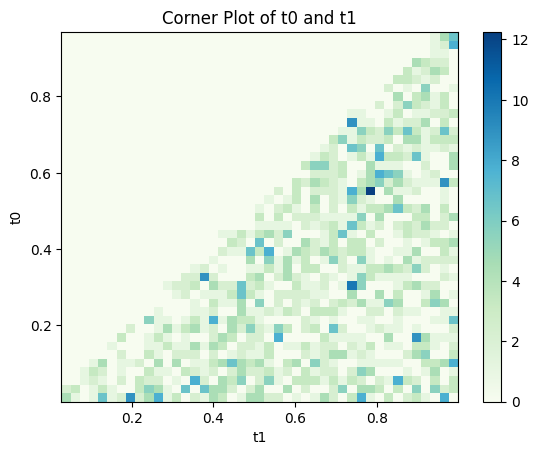

In [44]:
print("log Evidence: ", Gpresult3.get_evidence())
# Corner Plot between the two peak times
Gpresult3.corner_plot("t0", "t1")

<module 'matplotlib.pyplot' from '/Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/matplotlib/pyplot.py'>

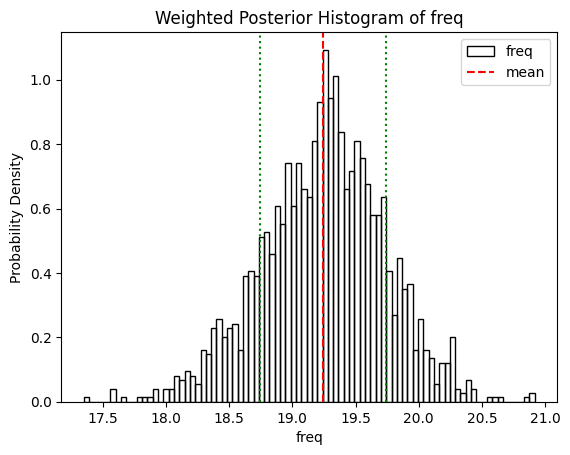

In [45]:
Gpresult3.weighted_posterior_plot("freq")

log Evidence:  -204.0424729376019


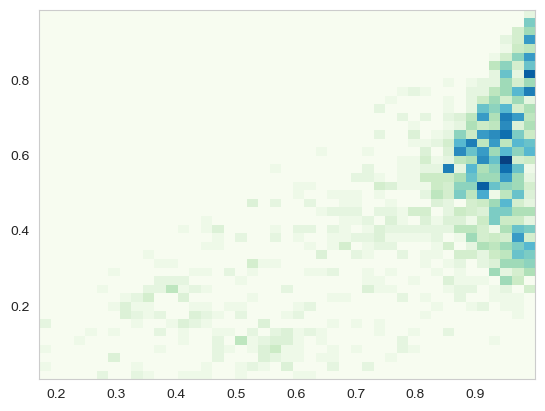

In [32]:
print("log Evidence: ", Gpresult3.get_evidence())

# Corner Plot between the two peak times
Gpresult3.corner_plot("t0", "t1")

On comapring the evidences of the two model we get the Bayes Factor.

For $M_1$ being QPO_plus_RN model and $M_2$ being the plain RN model.

$$
ln(BF) = ln(Z_1) - ln(Z_2) = -204.042 - (-214.292) = 10.25
$$

As BF is greater than 5.0, this gives us a strong indication that the time series has a Quasi Oscillatory behaviour.

Also, as we can see in the weighted posterior plot for the frequency, We had used a frequency of 20 Hz for our sample and this has been captured very well by the Nested Sampling Inference.

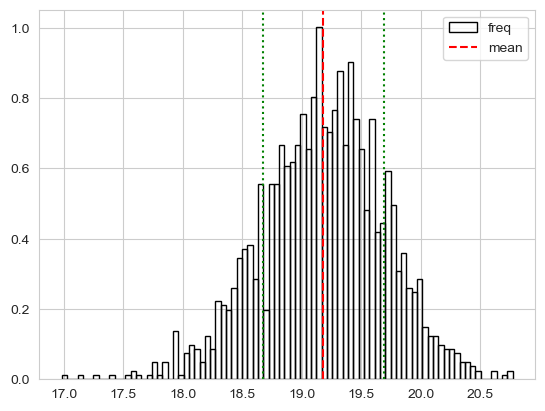

In [159]:
Gpresult3.weighted_posterior_plot("freq")

In [33]:
Gpresult3.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 619069
# samples: 8652
# slices: 238000.0
# slices / acceptance: 34.0
# likelihood evals / sample: 71.6
# likelihood evals / slice: 2.6
--------
logZ=-204.04 +- 0.14
H=200.0
ESS=1815
--------
A[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A[0]: 3.0 +- 1.5 | 1.1 / 2.9 / 5.0 | 1.0 | 1.0
A[1]: 3.4 +- 1.5 | 1.6 / 3.3 / 5.2 | 1.6 | 1.6
--------
aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
aqpo: 1.13 +- 0.62 | 0.72 / 0.94 / 1.73 | 0.8 | 0.8
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 10.8 +- 2.0 | 7.8 / 11.2 / 13.1 | 6.5 | 6.5
--------
cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cqpo: 1.63 +- 0.84 | 0.58 / 1.62 / 2.61 | 1.47 | 1.47
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 2.79 +- 0.71 | 2.12 / 2.57 / 3.65 | 4.49 | 4.49
--------
f

## Credits:

1. [Gaussian Process regression for astronomical time-series](https://arxiv.org/pdf/2209.08940.pdf), Suzanne Aigrain, Daniel Foreman-Mackey

2. [Bayesian Model Comparison](https://ned.ipac.caltech.edu/level5/Sept13/Trotta/Trotta4.html), Roberto Trotta

3. Searching for quasi-periodic oscillations in astrophysical transients using Gaussian processes, Moritz Hubner et al.